In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from scipy.spatial import distance

In [175]:
def load_initial(name):
    n_nodes = int(''.join(i for i in name if i.isdigit()))
    nodes = np.loadtxt(f"TSP/{name}.tsp.txt", skiprows = 6, max_rows = n_nodes)
    opt_tour = np.loadtxt(f"TSP/{name}.opt.tour.txt", skiprows = 5, max_rows = n_nodes)

    d_nodes = {}
    for node in nodes: 
        d_nodes[node[0]] = (node[1], node[2])

    return d_nodes, opt_tour

def plotnodes(nodes): 
    plt.figure(figsize = (9,9))

    for node, coordinates in nodes.items():
        plt.plot(coordinates[0], coordinates[1], 'ro')
        plt.annotate(int(node), (coordinates[0], coordinates[1]))

def plotedges(d_nodes, tour):
    x_route = [d_nodes[tour[0]][0]]
    y_route = [d_nodes[tour[0]][1]]

    for node in reversed(tour):
        x_route.append(d_nodes[node][0])
        y_route.append(d_nodes[node][1])

    plt.plot(x_route, y_route, color = 'grey')

def tour_length(d_nodes, tour):
    total_length = 0
    n_nodes = len(d_nodes)

    for i, node in enumerate(tour):
        x1 = d_nodes[node][0]
        y1 = d_nodes[node][1]
        x2 = d_nodes[tour[(i+1)%n_nodes]][0]
        y2 = d_nodes[tour[(i+1)%n_nodes]][1]
        
        total_length += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    return total_length

length = 429.98331198338406


<Figure size 1080x648 with 0 Axes>

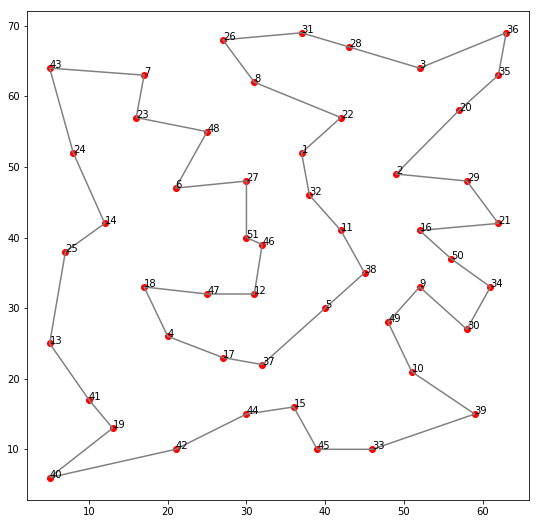

In [177]:
initial = load_initial("eil51")
plt.figure(figsize = (15,9))
plotnodes(initial[0])
plotedges(initial[0], initial[1])
print('length = ' + str(tour_length(initial[0], initial[1])))

In [178]:
# def make_d_nodes(nodes): 
#     d_nodes = {}

#     for node in nodes:
#         d_nodes[node[0]] = (node[1], node[2])

#     return d_nodes

# def make_tour_edges(tour): 
#     tour_edges = []

#     for i, node in enumerate(tour):
#         tour_edges.append([node, tour[(i+1)%len(tour)]])
    
#     return tour_edges

def make_distance_matrix(d_nodes):
    n_nodes = len(d_nodes)
    distance_matrix = np.zeros((n_nodes,n_nodes))
    
    for node1 in range(n_nodes):
        for node2 in range(n_nodes):
            x1 = d_nodes[node1+1][0]
            x2 = d_nodes[node2+1][0]
            y1 = d_nodes[node1+1][1]
            y2 = d_nodes[node2+1][1]

            distance_matrix[node1, node2] = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    return distance_matrix
    
def matrix_tour_length(tour, distance_matrix):
    total_distance = 0

    for i in range(len(tour)): 
        total_distance += distance_matrix[int(tour[i] - 1), int(tour[(i+1)%len(tour)] - 1)]
        
    return total_distance

def make_random_route(n_nodes):
    l_nodes = np.arange(1,n_nodes+1)
    return list(np.random.permutation(l_nodes))

In [ ]:
distance_matrixeil51 = make_distance_matrix(initial[0])

random_route = make_random_route(51)

plt.figure(figsize = (15,9))
plotnodes(initial[0])
plotedges(initial[0], random_route)
plt.show()

print(f'Length of tour = {matrix_tour_length(random_route, distance_matrixeil51)}')

tour = np.arange(1, 6)

In [326]:
def lin2opt(old_tour, dist): 
    # apply lin 2 opt to tour
    new_tour = old_tour[:]
    
    # making sure there are at least two nodes between the two random nodes,
    # otherwise reversing the subtour has no effect
    while True:
        random_nodes = random.sample(range(len(new_tour)), 2)
        
        if abs(random_nodes[0] - random_nodes[1]) >= 3:
            break

    i, j = min(random_nodes), max(random_nodes)

    subtour = new_tour[i + 1 : j]
    flipped_subtour = np.flip(subtour)
    new_tour[i + 1 : j] = flipped_subtour

    cost_diff = ((dist[new_tour[i] - 1, new_tour[(i+1)%len(new_tour)] - 1] + dist[new_tour[j-1] - 1, new_tour[j] - 1])
                -(dist[old_tour[i] - 1, old_tour[(i+1)%len(old_tour)] - 1] + dist[old_tour[j-1] - 1, old_tour[j] - 1]))
    
    return new_tour, cost_diff

def move_node(old_tour, dist):
    new_tour = old_tour[:]
    
    i, j = random.sample(range(len(new_tour)), 2)
    new_tour.insert(i, new_tour.pop(j))

    cost_offset = i < j
    cost_diff = ((dist[new_tour[i-1] - 1, new_tour[i] - 1] + dist[new_tour[i] - 1, new_tour[(i+1)%len(new_tour)] - 1] + dist[new_tour[j-1 + cost_offset] - 1, new_tour[(j + cost_offset)%len(new_tour)] - 1])
                -(dist[old_tour[j-1] - 1, old_tour[j] - 1] + dist[old_tour[j] - 1, old_tour[(j+1)%len(old_tour)] - 1] + dist[old_tour[i - cost_offset] - 1, old_tour[(i + 1 - cost_offset)%len(old_tour)] - 1]))

    return new_tour, cost_diff

In [329]:
def simulated_annealing(nodes, initial_tour, markov_chains, markov_length, initial_temp, cool_rate):
    tour = initial_tour
    temp = initial_temp

    distance_matrix = make_distance_matrix(nodes)

    # for plotting the costs per iteration
    costs = [matrix_tour_length(initial_tour, distance_matrix)]

    for i in range(markov_chains):
        print('\r', f"{i} out of {markov_chains}", end='')

        for _ in range(markov_length):
            if np.random.uniform() < 0.5:    
                new_tour, cost_diff = move_node(tour, distance_matrix)
            else:
                new_tour, cost_diff = lin2opt(tour, distance_matrix)

            # e^710 is too big to handle
            accept_prob = math.exp(min(709, -(cost_diff)/temp))

            if accept_prob >= 1 or np.random.uniform() <= accept_prob:
                tour = new_tour
                new_cost = costs[-1] + cost_diff
                costs.append(new_cost)
            else:
                costs.append(costs[-1])

        temp *= cool_rate

    plt.plot(range(len(costs)), costs)
    plt.show()

    return tour

 199 out of 200

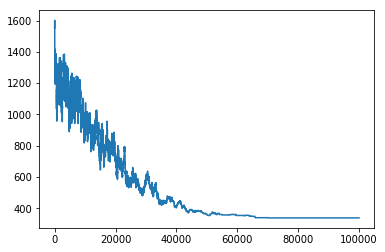

Length of found route: 435.66215505330507


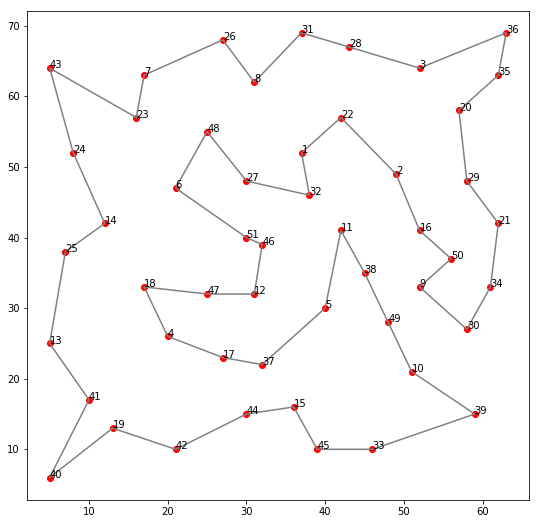

In [333]:
nodes = load_initial("eil51")[0]
annealed_tour = simulated_annealing(nodes, make_random_route(len(nodes)), 200, 500, 20, 0.975)
plotnodes(nodes)
plotedges(nodes, annealed_tour)
print(f"Length of found route: {tour_length(nodes, annealed_tour)}")

 499 out of 500

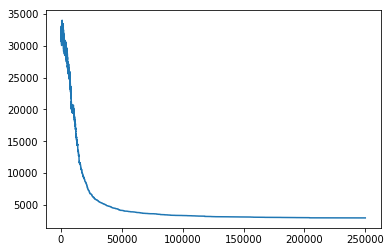

Length of found route: 2974.3823699009827


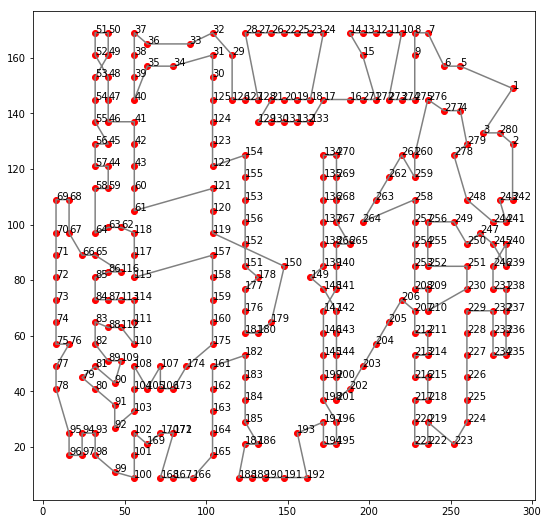

In [334]:
nodes = load_initial("a280")[0]
annealed_tour = simulated_annealing(nodes, make_random_route(len(nodes)), 500, 500, 400, 0.9)
plotnodes(nodes)
plotedges(nodes, annealed_tour)
print(f"Length of found route: {tour_length(nodes, annealed_tour)}")

In [42]:
# if we wanna save a tour, run this after generating it
with open('TSP_output/eil51_output.txt', 'w') as f:
    f.write("NAME : ./TSPLIB/a280.tsp.optbc.tour\nCOMMENT : Optimal tour for a280.tsp\nTYPE : TOUR\nDIMENSION : 280\nTOUR_SECTION\n")
    for city in annealed_tour:
        f.write(str(city))
        f.write('\n')